## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:Роор Даниил Дмитриевич

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

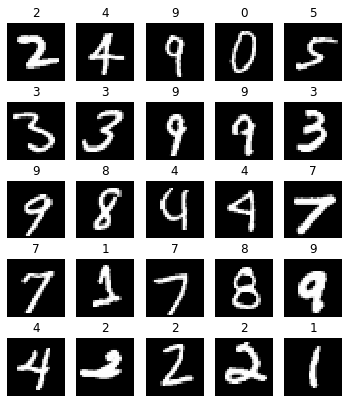

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [14]:
def layer_norm_init(layer, mean = 0, std = 0.1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean = mean, std = std)
    
def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward hook:', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward hook:', std)

In [15]:
def init_network(sizes, nonlinearity = nn.Sigmoid, layer_init_func = layer_norm_init):
    layers = []
    
    for size, next_size in zip(sizes, sizes[1:]):
        layer = nn.Linear(size, next_size)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)

        layer_init_func(layer)

        layers.append(layer)
        layers.append(nonlinearity())
    
    return nn.Sequential(*layers)

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [18]:
X = images_train.reshape(-1, 28 * 28)
sizes = [28 * 28] + [500] * 10 + [10]
NN = init_network(sizes, nonlinearity = nn.Tanh, layer_init_func = layer_norm_init)
res = NN(X)
res.mean().backward()

forward hook: 1.0270370244979858
forward hook: 0.851091206073761
forward hook: 0.7883514165878296
forward hook: 0.768684446811676
forward hook: 0.7680259943008423
forward hook: 0.7657543420791626
forward hook: 0.7656980156898499
forward hook: 0.7661644220352173
forward hook: 0.7658931612968445
forward hook: 0.766331672668457
forward hook: 0.764674186706543
backward hook: 0.004663486965000629
backward hook: 0.005622582975775003
backward hook: 0.005083966068923473
backward hook: 0.004955437500029802
backward hook: 0.0046123624779284
backward hook: 0.004348871298134327
backward hook: 0.004132766276597977
backward hook: 0.004342297557741404
backward hook: 0.004381939303129911
backward hook: 0.004290460608899593
backward hook: 0.003952798433601856


In [19]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = NN(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward hook: 1.0291306972503662
forward hook: 0.8510439991950989
forward hook: 0.7883517146110535
forward hook: 0.7683529257774353
forward hook: 0.7674961686134338
forward hook: 0.7654156684875488
forward hook: 0.7655132412910461
forward hook: 0.7660188674926758
forward hook: 0.7661408185958862
forward hook: 0.7661182284355164
forward hook: 0.7650118470191956
backward hook: 0.022823963314294815
backward hook: 0.006914952304214239
backward hook: 0.006877794861793518
backward hook: 0.006879307329654694
backward hook: 0.007129690609872341
backward hook: 0.007871382869780064
backward hook: 0.008361010812222958
backward hook: 0.009679889306426048
backward hook: 0.0114882942289114
backward hook: 0.013219652697443962
backward hook: 0.01212291233241558


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [21]:
def layer_xavier_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    d = 2 / (weight.size()[0] + weight.size()[1])
    weight.normal_(mean = 0, std = np.sqrt(d))

def layer_he_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    d = 2 / weight.size()[1]
    weight.normal_(mean = 0, std = np.sqrt(d))

1. Tanh + He

In [29]:
NN = init_network(sizes, nonlinearity = nn.Tanh, layer_init_func = layer_he_init)
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = NN(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward hook: 1.0291306972503662
forward hook: 0.7198925018310547
forward hook: 0.6329719424247742
forward hook: 0.5963006615638733
forward hook: 0.5760464072227478
forward hook: 0.5671021342277527
forward hook: 0.5639064311981201
forward hook: 0.5622390508651733
forward hook: 0.5620009303092957
forward hook: 0.5514994859695435
forward hook: 0.557012140750885
backward hook: 0.0249724630266428
backward hook: 0.01012901309877634
backward hook: 0.010269658640027046
backward hook: 0.009896604344248772
backward hook: 0.009526627138257027
backward hook: 0.00953163206577301
backward hook: 0.00921250693500042
backward hook: 0.008834621869027615
backward hook: 0.008308353833854198
backward hook: 0.007469188887625933
backward hook: 0.005823960993438959


2. Tanh + Xavier

In [23]:
NN = init_network(sizes, nonlinearity = nn.Tanh, layer_init_func = layer_xavier_init)
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = NN(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward hook: 1.0291306972503662
forward hook: 0.6560686230659485
forward hook: 0.49677541851997375
forward hook: 0.41183263063430786
forward hook: 0.36040034890174866
forward hook: 0.32876238226890564
forward hook: 0.30240753293037415
forward hook: 0.2815439701080322
forward hook: 0.26237377524375916
forward hook: 0.24487879872322083
forward hook: 0.23187553882598877
backward hook: 0.028203610330820084
backward hook: 0.017682431265711784
backward hook: 0.017504408955574036
backward hook: 0.01590009033679962
backward hook: 0.01571490429341793
backward hook: 0.014377242885529995
backward hook: 0.012037300504744053
backward hook: 0.010089396499097347
backward hook: 0.008590063080191612
backward hook: 0.006404902320355177
backward hook: 0.0038566843140870333


3. ReLU + He

In [24]:
NN = init_network(sizes, nonlinearity = nn.ReLU, layer_init_func = layer_he_init)
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = NN(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward hook: 1.0291306972503662
forward hook: 0.8447397947311401
forward hook: 0.8616323471069336
forward hook: 0.8662797808647156
forward hook: 0.8500365614891052
forward hook: 0.823026180267334
forward hook: 0.7812910676002502
forward hook: 0.7263763546943665
forward hook: 0.7381498217582703
forward hook: 0.7394446134567261
forward hook: 0.6844842433929443
backward hook: 0.04383047670125961
backward hook: 0.007629375904798508
backward hook: 0.0070122829638421535
backward hook: 0.0065826596692204475
backward hook: 0.005881495773792267
backward hook: 0.00523886363953352
backward hook: 0.005039558745920658
backward hook: 0.004797786008566618
backward hook: 0.004481921438127756
backward hook: 0.004018038045614958
backward hook: 0.003884127363562584


4. ReLU + Xavier

In [25]:
NN = init_network(sizes, nonlinearity = nn.ReLU, layer_init_func = layer_xavier_init)
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = NN(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward hook: 1.0291306972503662
forward hook: 0.6780850887298584
forward hook: 0.4758450388908386
forward hook: 0.337306946516037
forward hook: 0.24184249341487885
forward hook: 0.1716793179512024
forward hook: 0.11782879382371902
forward hook: 0.07701247185468674
forward hook: 0.053767915815114975
forward hook: 0.03877068683505058
forward hook: 0.026852784678339958
backward hook: 0.05012206733226776
backward hook: 0.010067240335047245
backward hook: 0.006735736969858408
backward hook: 0.004625234752893448
backward hook: 0.002953347284346819
backward hook: 0.0017929677851498127
backward hook: 0.0011101319687440991
backward hook: 0.000763190386351198
backward hook: 0.0004596523067448288
backward hook: 0.0003133970603812486
backward hook: 0.00019745828467421234


<i> 1.4 Сделайте выводы по первой части </i>

Инициализация He лучше сохраняет дисперсию данных

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [36]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p = 0.5, mean = 0, std = 0.01):
        super(DropConnect, self).__init__()
        self.layer = nn.Linear(input_dim, output_dim)
        layer_norm_init(self.layer, mean = mean, std = std)
        self.w, self.b = self.layer.parameters()
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.zeros_like(self.w).bernoulli_(self.p) 
        else:
            mask = torch.ones_like(self.w) * self.p
        mask = mask.data
        output = torch.mm(x, (self.w * mask).transpose(0, 1)) + self.b
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 

</i>

In [31]:
layers = [nn.Flatten()]

sizes = [784, 200, 200, 10]
for size, next_size in zip(sizes, sizes[1:]):
    layers.append(nn.Linear(size, next_size))  
    if next_size != 10:
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.5))
    else:
        layers.append(nn.LogSoftmax())

net1 = nn.Sequential(*layers)

Epoch 4... (Train/Test) NLL: 0.600/0.351	Accuracy: 0.847/0.922


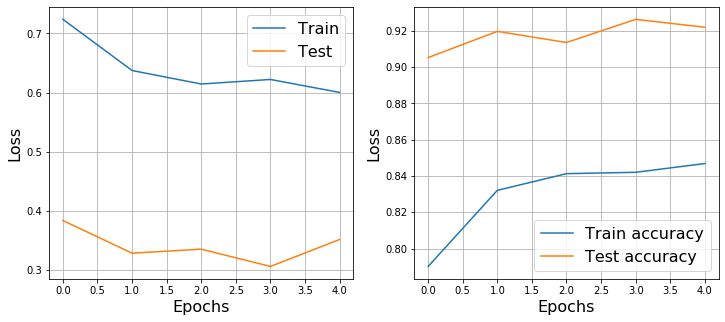

([0.723802981091969,
  0.6371961585494247,
  0.6143967095595687,
  0.6220656794779844,
  0.6001610449636414],
 [0.38337807753418063,
  0.3280973631558539,
  0.3348840478854843,
  0.30565081131231936,
  0.3512843590748461],
 [0.79015076, 0.83208954, 0.84128463, 0.8420342, 0.846865],
 [0.9052611, 0.9196994, 0.913568, 0.92632514, 0.9219739])

In [32]:
from train_utils import train
train(net1, train_loader, test_loader, 5, 0.01)

2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев

In [37]:
layers = [nn.Flatten()]

sizes = [784, 200, 200, 10]
for size, next_size in zip(sizes, sizes[1:]):
    if next_size != 10:
        layers.append(DropConnect(size, next_size, 0.5))
        layers.append(nn.ReLU())
    else:
        layers.append(nn.Linear(size, next_size))
        layers.append(nn.LogSoftmax())

net2 = nn.Sequential(*layers)

Epoch 4... (Train/Test) NLL: 0.261/0.144	Accuracy: 0.931/0.958


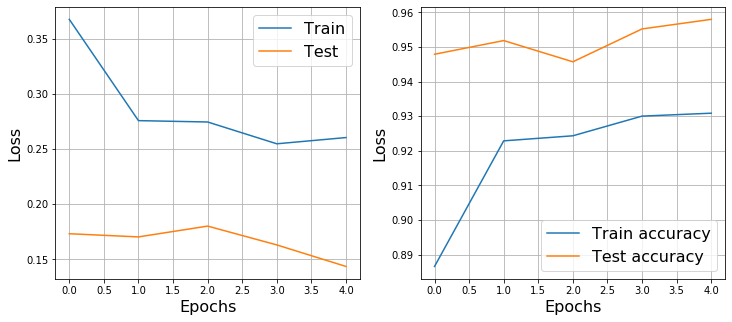

([0.3679280402118972,
  0.27596547278259864,
  0.27473744385039756,
  0.254939683210621,
  0.26059889193695746],
 [0.17328096332052087,
  0.17038895185046557,
  0.18020717509656767,
  0.1631118357181549,
  0.14357144022478333],
 [0.8865827, 0.9228689, 0.9243292, 0.93001515, 0.9308591],
 [0.9478837, 0.9518394, 0.9457081, 0.95520175, 0.95797074])

In [38]:
from train_utils import train
train(net2, train_loader, test_loader, 5, 0.01)

<i> 2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике </i>

Dropconnect показал лучшие результаты по Accuracy и NLLLoss, чем Dropout

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [39]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):

    def __init__(self, n_features, eps = 1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(n_features))
        self.beta = nn.Parameter(torch.zeros(n_features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim = True)
        std = x.std(-1, keepdim = True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 4... (Train/Test) NLL: 0.040/0.078	Accuracy: 0.986/0.976


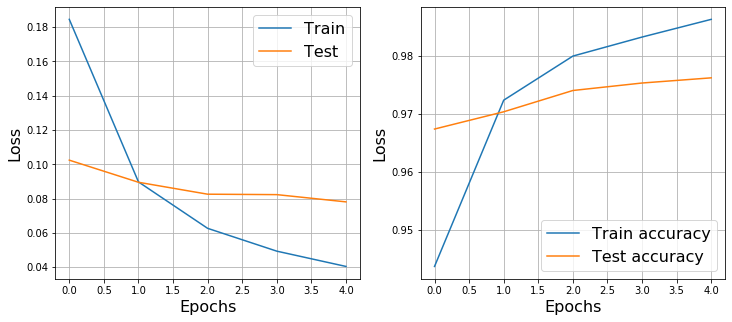

([0.1844957962409774,
  0.08975748302959112,
  0.0626860339847852,
  0.049389639133110896,
  0.04047846075977439],
 [0.10243123802769033,
  0.0895397627631886,
  0.08258886897606374,
  0.08233587468585259,
  0.07811224674864943],
 [0.94375217, 0.9723259, 0.9799052, 0.98317564, 0.9862185],
 [0.9673655, 0.97033226, 0.9739913, 0.9752769, 0.9761669])

In [46]:
network = nn.Sequential(nn.Flatten(),
                        nn.Linear(784, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, train_loader, test_loader, 5, 0.01)

Epoch 4... (Train/Test) NLL: 0.050/0.066	Accuracy: 0.984/0.979


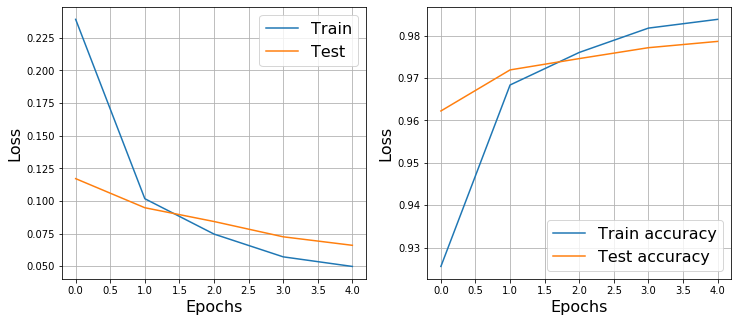

([0.23919203805167283,
  0.1017201397655361,
  0.07462763814513744,
  0.0571725152587808,
  0.0498114969945753],
 [0.11710579066148287,
  0.09481169836289144,
  0.08425123895270915,
  0.07253411895583702,
  0.0660122905421672],
 [0.92553973, 0.9683557, 0.976035, 0.98177636, 0.98384196],
 [0.9622231, 0.9719145, 0.97458464, 0.97715586, 0.97863925])

In [47]:
network = nn.Sequential(nn.Flatten(),
                        nn.Linear(784, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, train_loader, test_loader, 5, 0.01)

<i> 3.3 Сделайте выводы по третьей части </i>

Layer Normalization показала лучший результат на тесте и худший на трейне по сравнению с Batch Normalization

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: